In [1]:
# --- PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx, degree
# --- NetworkX
import networkx as nx
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
# --- Modules from local files
from GNN.GNN_atom import GNN, GNN_node, nnconv, PNA, UniMP
from dataset import XASDataset_atom
from utils.model import train_model, val_test
from utils.utils import plot_learning_curve

#### Load dataset

In [2]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset_atom(path)

Processing...


Total number of molecules 317


Done!


In [3]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

#torch.save(dataset, './datasets/atom_dataset_long_7895.pt')

XASDataset_atom(7895)
------------
Number of graphs: 7895
Number of features: 15
Number of classes: 2

Data(x=[27, 15], edge_index=[2, 72], edge_attr=[72, 3], y=[6], spectrum=[200], pos=[27, 3], z=[27], idx=[1], atom_num=[1], smiles='c12[c:4]3[c:6]4[c:7]([H:29])[c:9]([H:30])[c:10]5[c:8]3[c:12]3[c:16]6[c:20]1[C:22]1([C:21]([H:36])=[C:19]([H:37])[C:18]6=[C:17]([H:40])[C:15]([H:38])([H:39])[C:14]36[C:13]([H:32])([C:11]5([H:31])[H:35])[O:26]6)[C:23]([H:33])([C:1]([H:27])([H:34])[C:2]23[C:3]([H:28])([C:5]4([H:41])[H:42])[O:24]3)[O:25]1')
------------
Number of nodes: 27
Number of edges: 72
Average node degree: 2.67
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [10]:
print(dataset[0].smiles)
print(dataset[1].smiles)
print(dataset[2].atom_num)

c12[c:4]3[c:6]4[c:7]([H:29])[c:9]([H:30])[c:10]5[c:8]3[c:12]3[c:16]6[c:20]1[C:22]1([C:21]([H:36])=[C:19]([H:37])[C:18]6=[C:17]([H:40])[C:15]([H:38])([H:39])[C:14]36[C:13]([H:32])([C:11]5([H:31])[H:35])[O:26]6)[C:23]([H:33])([C:1]([H:27])([H:34])[C:2]23[C:3]([H:28])([C:5]4([H:41])[H:42])[O:24]3)[O:25]1
c12[c:4]3[c:6]4[c:7]([H:29])[c:9]([H:30])[c:10]5[c:8]3[c:12]3[c:16]6[c:20]1[C:22]1([C:21]([H:36])=[C:19]([H:37])[C:18]6=[C:17]([H:40])[C:15]([H:38])([H:39])[C:14]36[C:13]([H:32])([C:11]5([H:31])[H:35])[O:26]6)[C:23]([H:33])([C:1]([H:27])([H:34])[C:2]23[C:3]([H:28])([C:5]4([H:41])[H:42])[O:24]3)[O:25]1
tensor([6])


In [6]:
data.y

tensor([0, 0, 0, 0, 0, 1])

#### View data

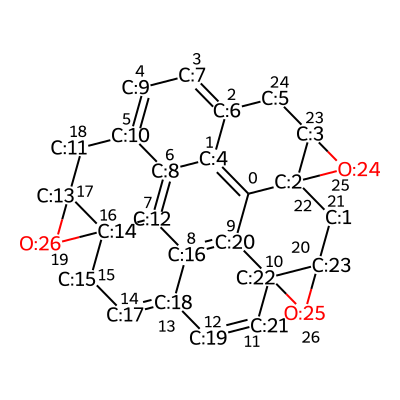

In [9]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

In [12]:
# --- Define the functional group fragments to search for
oh_frag = Chem.MolFromSmarts('[#6][OX2H]')
cooh_frag = Chem.MolFromSmarts('[CX3](=[OX1])O')
epo_frag = Chem.MolFromSmarts('[#6]-[O]-[#6]')
ald_frag = Chem.MolFromSmarts('[CX3H1](=O)')
ket_frag = Chem.MolFromSmarts('[CX3C](=O)')

# --- Search mol for functional group matches
oh_match = mol.GetSubstructMatches(oh_frag)
cooh_match = mol.GetSubstructMatches(cooh_frag)
epo_match = mol.GetSubstructMatches(epo_frag)
ald_match = mol.GetSubstructMatches(ald_frag)
ket_match = mol.GetSubstructMatches(ket_frag)

# --- Turn match n-dimensional tuples to 1D list
oh_list = list(sum(oh_match, ()))
cooh_list = list(sum(cooh_match, ()))
epo_list = list(sum(epo_match, ()))
ald_list = list(sum(ald_match, ()))
ket_list = list(sum(ket_match, ()))

In [15]:
for atom in mol.GetAtoms():
    if mol.GetSubstructureMatches(epo_frag) == True:
        print('yes')

AttributeError: 'Mol' object has no attribute 'GetSubstructureMatches'

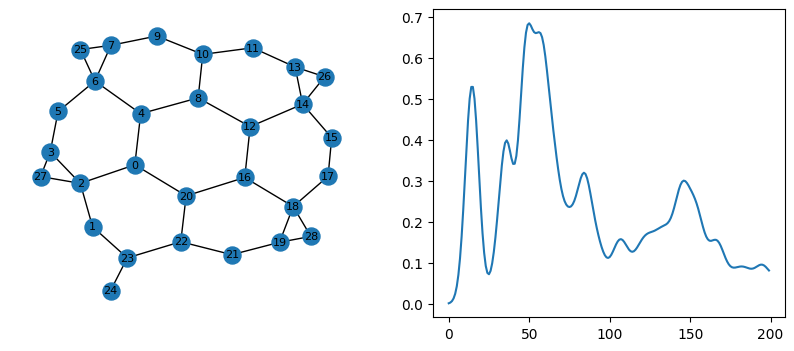

In [16]:
# --- Create subplot for 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show an atomic spectrum from molecule
ax2.plot(data.spectrum)
plt.show()

#### Set up dataset for model

In [6]:
# --- Split into test, validation and test
train_dataset = dataset[:500]
val_dataset = dataset[6001:6051]
test_dataset = dataset[7000:7895]

# train_dataset = dataset[:238]
# val_dataset = dataset[239:268]
# test_dataset = dataset[269:]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datasets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

# torch.save(test_dataset, './datasets/atom_test_dataset_long_7895.pt')

Length of training data loader: 500, with a total of 5 datasets
Length of validation data loader: 50, with a total of 1 datasets
Length of testing data loader: 895, with a total of 895 datasets


#### Set up neural network

In [7]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 64, 128]
out_channels = [64, 128, 256]
gnn_type = 'gcn'
heads = 1
drop_ratio = 0.0
graph_pooling = 'mean'

max_degree = -1
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

deg = torch.zeros(max_degree + 1, dtype=torch.long)
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

GNN(
  (convs): ModuleList(
    (0): GCNConv(15, 64)
    (1): GCNConv(64, 128)
    (2): GCNConv(128, 256)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): Linear(in_features=256, out_features=200, bias=True)
)
----
Training will be performed on: cpu


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
configs = {
      'device': device,
      'num_layers': 3,
      # The paper use 128 hidden dim, but we use 64 here due to resourse limitation.
      # Similar issues were found in https://github.com/pyg-team/pytorch_geometric/discussions/3388
      # We found this as a limitation of using transformer layer.
      'hidden_dim': 64,
      'num_heads': 1,
      'dropout': 0.3,
      'lr':  0.001,
      'epochs': 500,
      "weight_decay":0.0005,
      'output_dim': 200
  }

model = UniMP(data.num_features, configs['hidden_dim'],
            configs['output_dim'], configs['num_layers'],
            configs['dropout'], heads=configs['num_heads']).to(device)
print(model)

UniMP(
  (convs): ModuleList(
    (0): TransformerConv(15, 64, heads=1)
    (1): TransformerConv(64, 64, heads=1)
    (2): TransformerConv(64, 200, heads=1)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, min_lr=0.000001)

#### Training the neural network

In [10]:
num_epochs = 400
train_losses = []
val_losses = []
embedding = []

for epoch in range(num_epochs):
    train_loss, embedding = train_model(model, train_loader, optimizer, device)

    # if epoch == 299:
    #     for x in node_embedding:
    #         embedding.append(x)

    val_loss, out, true = val_test(model, val_loader, device)

    plt.plot(out)
    plt.plot(true)
    plt.ylim(-0.2, 1.2)
    plt.xlim(0, 200)
    plt.title(f'epoch: {epoch}')
    plt.savefig(f'./images/graph_{epoch}.png')
    plt.close()

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']

    if epoch%25 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:5f}, TrainLoss: {train_loss:.7f}, ValLoss: {val_loss:7f}')

print('--------------')
print(f'Final training loss value of: {train_loss:.5f} and validation loss of: {val_loss:.5f}')

Epoch: 000, LR: 0.010000, TrainLoss: 0.1278378, ValLoss: 0.056910
Epoch: 025, LR: 0.010000, TrainLoss: 0.0188026, ValLoss: 0.028183
Epoch: 050, LR: 0.010000, TrainLoss: 0.0140423, ValLoss: 0.022625
Epoch: 075, LR: 0.010000, TrainLoss: 0.0093801, ValLoss: 0.024740
Epoch: 100, LR: 0.005000, TrainLoss: 0.0064253, ValLoss: 0.026916
Epoch: 125, LR: 0.002500, TrainLoss: 0.0049668, ValLoss: 0.029353
Epoch: 150, LR: 0.001250, TrainLoss: 0.0042534, ValLoss: 0.030355
Epoch: 175, LR: 0.000625, TrainLoss: 0.0038430, ValLoss: 0.031572
Epoch: 200, LR: 0.000313, TrainLoss: 0.0036251, ValLoss: 0.031774
Epoch: 225, LR: 0.000156, TrainLoss: 0.0035617, ValLoss: 0.032175
Epoch: 250, LR: 0.000078, TrainLoss: 0.0035627, ValLoss: 0.032149
Epoch: 275, LR: 0.000039, TrainLoss: 0.0035134, ValLoss: 0.032130
Epoch: 300, LR: 0.000020, TrainLoss: 0.0034564, ValLoss: 0.032199
Epoch: 325, LR: 0.000010, TrainLoss: 0.0034097, ValLoss: 0.032270
Epoch: 350, LR: 0.000005, TrainLoss: 0.0033478, ValLoss: 0.032207
Epoch: 375

In [11]:
frames = []

for t in range(num_epochs):
    image = imageio.v2.imread(f'./images/graph_{t}.png')
    frames.append(image)

imageio.mimsave('./training.gif', frames, fps=8)

In [11]:
model_name = 'model_gnn_atom_test.pt'
torch.save(model.state_dict(), 'ML_models/' + model_name)

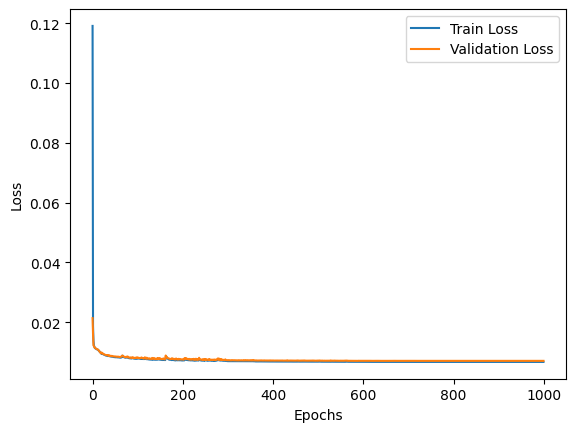

In [12]:
plot_learning_curve(num_epochs, train_losses, val_losses)

In [13]:
model.load_state_dict(torch.load('ML_models/' + model_name, map_location='cpu'))

<All keys matched successfully>

In [14]:
model.eval()
model_pred = []
model_data = []

for data in test_loader:
    data = data.to(device)

    with torch.no_grad():
        pred = model(data)
        model_pred.append(pred)
        model_data.append(data.spectrum)    

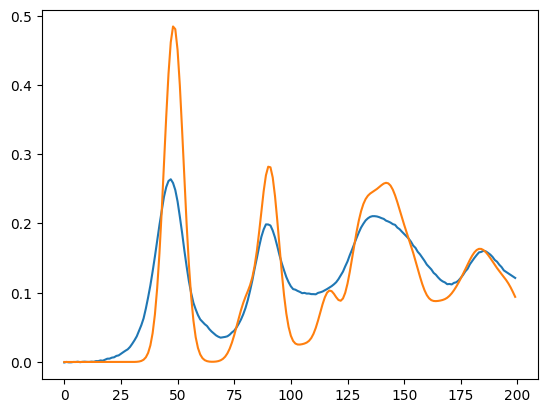

In [17]:
plt.plot(model_pred[0][15].detach().cpu().numpy())
plt.plot(model_data[0][15].detach().cpu().numpy())
plt.show()

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE

trans = transform(n_components=2, perplexity=30, early_exaggeration=12, n_iter=1000)
x_reduced = trans.fit_transform(embedding.cpu().detach().numpy())
x_reduced.shape

(100, 2)

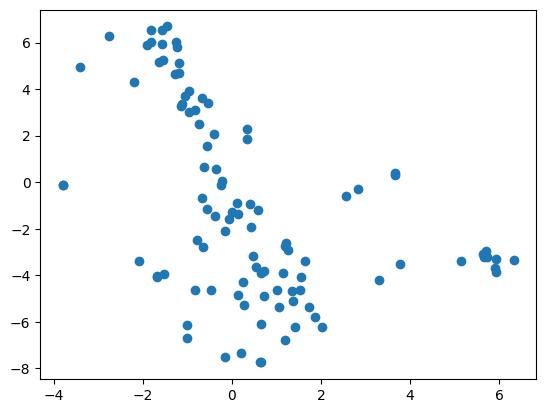

In [36]:
plt.scatter(x_reduced[:,0], x_reduced[:,1])
plt.show()

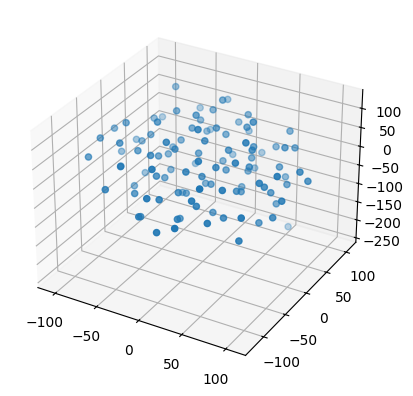

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x_reduced[:,0], x_reduced[:,1], x_reduced[:,2])
plt.show()

In [29]:
pca = PCA(n_components=2)
pca_fit = pca.fit(embedding.cpu().detach().numpy())

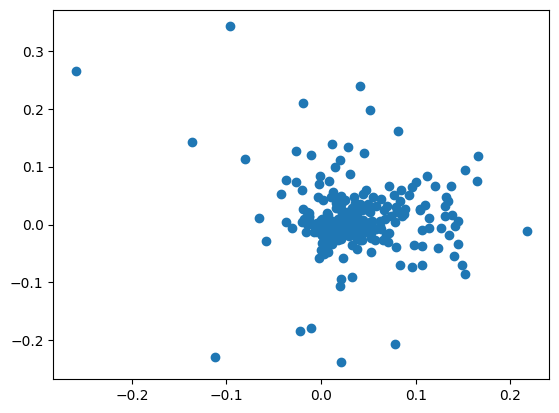

In [30]:
plt.scatter(pca_fit.components_[0], pca_fit.components_[1])
plt.show()